### Video Link

https://youtu.be/jjbkAn3vpIs

# COGS 108 - Bitcoin Sentiment Analysis Project

# Names

- Parv Chordiya
- Vivek Rane
- Sonakshi Mohanty
- Rahul Bulsara

# Overview

Our project will analyze the trend of the value of the cryptocurrency Bitcoin compared to social media, more specifically tweets that discuss Bitcoin or has any relevance towards it. We explored this by gathering data from Kaggle of the historical price of Bitcoin along with tweets that mention it from Twitter. After gathering and cleaning up our data, we were able to find the relationship between Bitcoin price and social media and ultimately found that there does not exist a relationship. There are not any positive nor negative trends in tweets from individuals that can directly influence the value of the cryptocurrency.


# Research Question

Can we identify a measurable correlation between specific social media sentiment indicators (such as counts of positive, neutral, and negative posts) on platforms like X (formerly Twitter), and key Bitcoin price metrics? Specifically, we aim to analyze whether changes in sentiment on these platforms are associated with variations in Bitcoin’s price volatility, daily closing price, and trading volume over defined time frames.

In this project, sentiment will be measured by categorizing posts as positive, neutral, or negative based on commonly used sentiment indicators. We will then examine how these sentiment trends align with Bitcoin's price action and trading activity, using statistical analysis to determine any significant correlations.


## Background and Prior Work

In recent years, social media has changed the way information spreads, and it’s even had a big impact on financial markets. This is especially true for the cryptocurrency market and Bitcoin in particular. Because Bitcoin is decentralized and its price is highly volatile, it’s more sensitive to public opinion and speculation. Platforms like Twitter and Reddit have become central spaces where people express their views about Bitcoin, often influencing its price. A famous example of this is how Elon Musk’s tweets can send Bitcoin prices soaring or dropping, showing just how much social media sentiment can drive market behavior^1.

Previous studies have looked into this connection between social media sentiment and Bitcoin prices, and they’ve uncovered some interesting patterns. One notable study used Twitter data to gauge “public mood” and see how it affects Bitcoin price volatility. They found that major price shifts often happened in response to swings in public sentiment on Twitter. By analyzing the positive and negative tones of tweets, this study showed a significant link between these sentiments and Bitcoin’s price changes, particularly when the market was very volatile^2. Another study looked at Reddit’s cryptocurrency discussions, analyzing how the amount and sentiment of posts impacted Bitcoin prices. They observed that sudden increases in positive or negative discussions were often followed by price changes, suggesting that social media sentiment can lead to short-term trading behavior that affects prices^3.

While a lot of research has been done on Bitcoin’s price volatility and market trends, combining social media sentiment analysis with Bitcoin price prediction is still a developing area. This project aims to build on what we know by using sentiment analysis to measure the real-time impact of Twitter and Reddit on Bitcoin prices, hoping to see if we can make accurate price predictions based on sentiment trends. By mixing sentiment analysis with time series modeling, this project seeks to deepen our understanding of the relationship between social media and cryptocurrency markets, adding to ongoing research on how online platforms influence financial markets.

Rani Molla(2021, June 14). When Elon Musk tweets, crypto prices move.https://www.vox.com/recode/2021/5/18/22441831/elon-musk-bitcoin-dogecoin-crypto-prices-tesla.

Abraham, J., Higdon, D., Nelson, J., & Ibarra, J. (2018). "Cryptocurrency price prediction using tweet volumes and sentiment analysis.https://api.semanticscholar.org/CorpusID:52950647

Oliveira, N., Cortez, P., & Areal, N. (2017). The impact of microblogging data for stock market prediction: Using Twitter to predict returns, volatility, trading volume and survey sentiment indices. Expert Syst. Appl., 73, 125-144.https://doi.org/10.1016/j.im.2017.10.004. ^ https://api.semanticscholar.org/CorpusID:21682466


# Hypothesis


We hypothesize that there is a positive correlation between social media sentiment toward Bitcoin and Bitcoin's price metrics. Specifically:

Positive Sentiment Hypothesis: Increases in the proportion of positive mentions of Bitcoin on social media platforms like X (formerly Twitter) and Reddit (categorized based on words or phrases associated with optimism, such as "bullish," "gains," or "buy") will be associated with an increase in Bitcoin's closing price, trading volume, or price volatility.

Negative Sentiment Hypothesis: Conversely, increases in the proportion of negative mentions (identified by terms reflecting pessimism, such as "bearish," "losses," or "sell") will correlate with a decrease in these metrics.

For clarity, sentiment will be categorized into positive, neutral, or negative based on keyword counts and sentiment scoring rules that classify posts according to commonly accepted standards. We expect that shifts in sentiment will show a measurable impact on Bitcoin’s price metrics, reflecting the influence of public opinion on market trends.

# Data

Importing required packages

In [1]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data overview

Bitcoin Historical Data

- [Link to the dataset](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data/data?select=btcusd_1-min_data.csv)
- Number of observations: ~ 6,712,281
- Number of variables: 6

Bitcoin Tweets

- [Link to the dataset](https://www.kaggle.com/datasets/kaushiksuresh147/bitcoin-tweets)
- Number of observations: ~ 4,689,354
- Number of variables: 13

Bitcoin Historical Data: This dataset includes historical bitcoin market data at 1-min intervals for select bitcoin exchanges where trading takes place. The important variables in this dataset are # Open which tells us the opening price of Bitcoin for the day and # Close which tells us the value of Bitcoin at the end of that day. # Volume is also insightful as it tells us the volume of Bitcoin transacted during that day. This dataset is quite extensive as it started in 2012. We will most likely clean it by only keeping observations from 2021 to the present as this timeframe is included in our Bitcoin Tweets dataset.

Bitcoin Tweets: This dataset contains tweets from Twitter/X that contain the #Bitcoin and #Btc hashtags. This collection started on 6/2/2021 and is updated daily. An important variable in this dataset are date which tells us the UTC time and date when the tweet was posted. We’ll be able to see the price of Bitcoin at the time of these tweets by combining this dataset with the Bitcoin Historical Data. Another important variable is text which gives us the actual content of the tweets. We’ll use sentiment scoring rules to classify tweets as being either negative or positive. More information about our sentiment analysis is included in our hypothesis.

## Bitcoin Historical Data

In [ ]:
btc_df = pd.read_csv("/Users/rahulbulsara/Downloads/btcusd_1-min_data.csv")
btc_df

### Bitcoin Data Wrangling

Convert index into `datetime`

In [ ]:
btc_df['Timestamp'] = pd.to_datetime(btc_df['Timestamp'], unit='s', utc=True)
btc_df.set_index('Timestamp', inplace=True)


Check for and drop any columns with missing values

In [ ]:
missing_values = btc_df.isnull().sum()
print("Missing values per column:\n", missing_values)

In [ ]:
btc_df.dropna(inplace=True)


Resample data to hourly

In [ ]:
btc_hourly = btc_df.resample('h').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

In [ ]:
btc_hourly

## Bitcoin Tweets 

In [ ]:
tweets_df = pd.read_csv("C:/Users/User/Documents/cogs108_data/Bitcoin_tweets.csv", usecols=['user_followers', 'date', 'text'])



### Bitcoin tweets Data Wrangling

Set index to `datetime` and drop any tweets that don't have valid dates

In [ ]:
tweets_df['tweet_datetime'] = pd.to_datetime(tweets_df['date'], utc=True, errors='coerce')
tweets_df.dropna(subset=['tweet_datetime'], inplace=True)

tweets_df.set_index('tweet_datetime', inplace=True)


Clean the tweets getting rid of any URLs, emojis and special characters, punctuation, numbers, and whitespaces.

In [ ]:
def clean_tweet_text(text):
    text = str(text)
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove mentions and hashtags
    #text = re.sub(r'@\w+|#\w+', '', text)
    # Remove emojis and special characters
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()
    return text.lower()


In [ ]:
tweets_df['cleaned_text'] = tweets_df['text'].apply(clean_tweet_text)


Make sure no tweets are empty after cleaning, and only store those that are not.

In [ ]:
tweets_df = tweets_df[tweets_df['cleaned_text'] != '']

Sort by datetime

In [ ]:
tweets_df.sort_index(inplace=True)

# Results

## Bitcoin Tweet Sentiment on Bitcoin Price Action analysis

## Sentiment Analysis

We apply the SentimentIntensityAnalyzer to get the polarity scores for each cleaned tweet in our dataset.

Polarity in sentiment analysis refers to the degree of positivity, negativity, or neutrality expressed in a piece of text. It quantifies sentiment on a scale, typically ranging from -1 (strongly negative) to +1 (strongly positive), with 0 representing a neutral sentiment. it is crucial in understanding the emotional tone of social media posts, reviews, or any textual content.








In [ ]:
sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

tweets_df['sentiment_score'] = tweets_df['cleaned_text'].apply(get_sentiment_score)


We then categorize each polarity score as positive, neutral, or negative. Since neutral tweets will be 0 or very close to 0, a very small range is used for encoding them.

In [ ]:
def categorize_sentiment(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

tweets_df['sentiment_category'] = tweets_df['sentiment_score'].apply(categorize_sentiment)


Group the data by hour, just like our bitcoin data.

In [ ]:
sentiment_counts = tweets_df.groupby([pd.Grouper(freq='h'), 'sentiment_category']).size().unstack(fill_value=0)

Make sure each category exists for each hour of data and fill in with 0 if not.

In [ ]:
for category in ['positive', 'neutral', 'negative']:
    if category not in sentiment_counts.columns:
        sentiment_counts[category] = 0


Compute features, `total_tweets`, `net_sentiment_score` and `average_sentiment`. 

`net_sentiment_score` is simply the net amount of directional(positive or negative) tweets divided by total number of tweets.

`average_sentiment` is the mean uncategorized sentiment score across each hour

In [ ]:
sentiment_counts['total_tweets'] = sentiment_counts.sum(axis=1)


In [ ]:
sentiment_counts['net_sentiment_score'] = (sentiment_counts['positive'] - sentiment_counts['negative']) / sentiment_counts['total_tweets']


In [ ]:
average_sentiment = tweets_df.resample('h')['sentiment_score'].mean()
sentiment_counts['average_sentiment'] = average_sentiment

Since our data is missing certain days, we need to filter our bitcoin data to only include days which we have tweets for.

In [ ]:
available_hours = sentiment_counts.index.unique()
btc_filtered = btc_hourly.loc[btc_hourly.index.isin(available_hours)]

We can now merge both of our fully proceessed datasets into one.

In [ ]:
sentiment_counts = sentiment_counts.reindex(btc_filtered.index)

In [ ]:
merged_df = btc_filtered.join(sentiment_counts, how='inner')

## Analyzing Relationship between Sentiment and Bitcoin Price Action

Lets start with plotting out our data:

In [3]:
merged_df = pd.read_csv(r'C:\Users\User\Group017-FA24\Group017-FA24\Data\mergedData.csv', index_col=0)
merged_df

,Open,High,Low,Close,Volume,negative,neutral,positive,total_tweets,net_sentiment_score,average_sentiment
Timestamp,,,,,,,,,,,
2021-02-05 10:00:00+00:00,37302.24,37391.12,37049.34,37094.46,97.855257,0,5,6,11,0.545455,0.274245
2021-02-05 11:00:00+00:00,37094.46,37700.43,37060.00,37431.08,227.234701,10,47,31,88,0.238636,0.109375
2021-02-05 12:00:00+00:00,37430.83,37777.78,37430.83,37706.73,152.645297,12,59,68,139,0.402878,0.192934
2021-02-05 13:00:00+00:00,37714.98,37836.97,37462.33,37771.16,255.330184,15,68,48,131,0.251908,0.130253
2021-02-05 14:00:00+00:00,37766.09,37817.53,37250.00,37301.38,189.317303,15,82,63,160,0.300000,0.135852
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-09 19:00:00+00:00,17225.00,17268.00,17211.00,17263.00,33.898095,251,680,615,1546,0.235446,0.125101
2023-01-09 20:00:00+00:00,17263.00,17328.00,17230.00,17271.00,128.415261,248,705,630,1583,0.241314,0.128724
2023-01-09 21:00:00+00:00,17270.00,17355.00,17270.00,17325.00,150.895088,214,518,591,1323,0.284958,0.150869


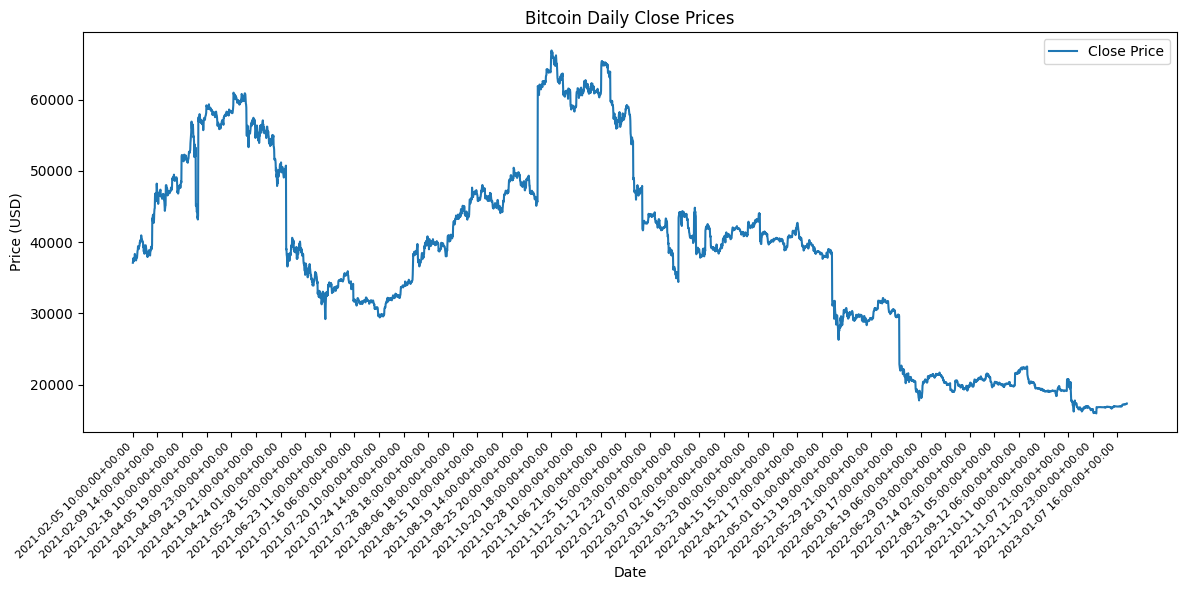

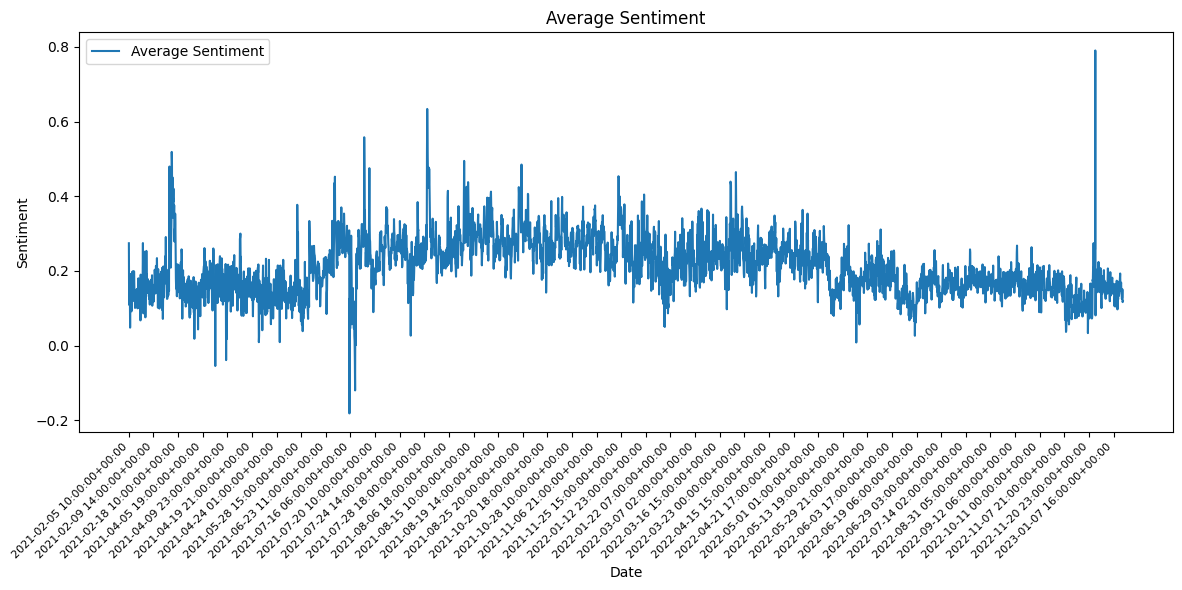

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['Close'], label='Close Price')
plt.title('Bitcoin Daily Close Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

n = len(merged_df.index) // 40  
plt.xticks(merged_df.index[::n])

plt.xticks(rotation=45, ha='right', fontsize=8) 
plt.tight_layout() 

plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['average_sentiment'], label='Average Sentiment')
plt.title('Average Sentiment')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()

n = len(merged_df.index) // 40  
plt.xticks(merged_df.index[::n])

plt.xticks(rotation=45, ha='right', fontsize=8)  
plt.tight_layout() 


plt.show()

The sentiment is very noisy and exists on a completely different scale than the price action of BTC, lets scale both metrics and replot.

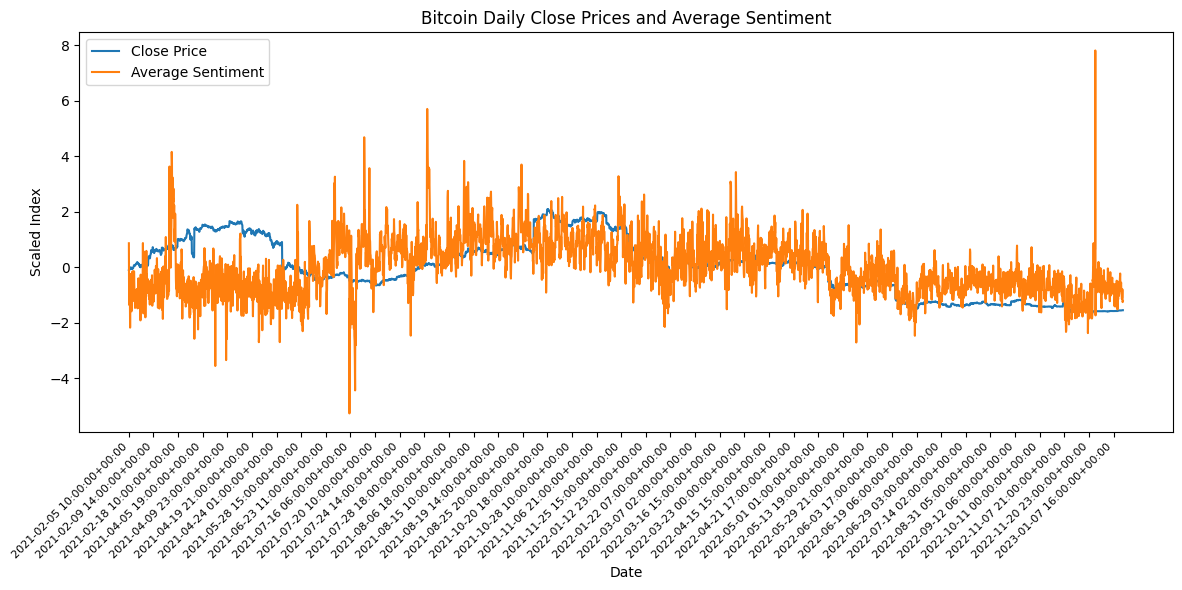

In [108]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
merged_df_scaled = scaler.fit_transform(merged_df)
merged_df_scaled = pd.DataFrame(merged_df_scaled, columns=merged_df.columns, index=merged_df.index)

plt.figure(figsize=(12, 6))

plt.plot(merged_df_scaled.index, merged_df_scaled['Close'], label='Close Price')

plt.plot(merged_df_scaled.index, merged_df_scaled['average_sentiment'], label='Average Sentiment') 

plt.title('Bitcoin Daily Close Prices and Average Sentiment')
plt.xlabel('Date')
plt.ylabel('Scaled Index') 
plt.legend()

n = len(merged_df_scaled.index) // 40  
plt.xticks(merged_df_scaled.index[::n])

plt.xticks(rotation=45, ha='right', fontsize=8) 

plt.tight_layout() 

plt.show()


Anaylsing the correlation between all the features might give us some insight aswell.

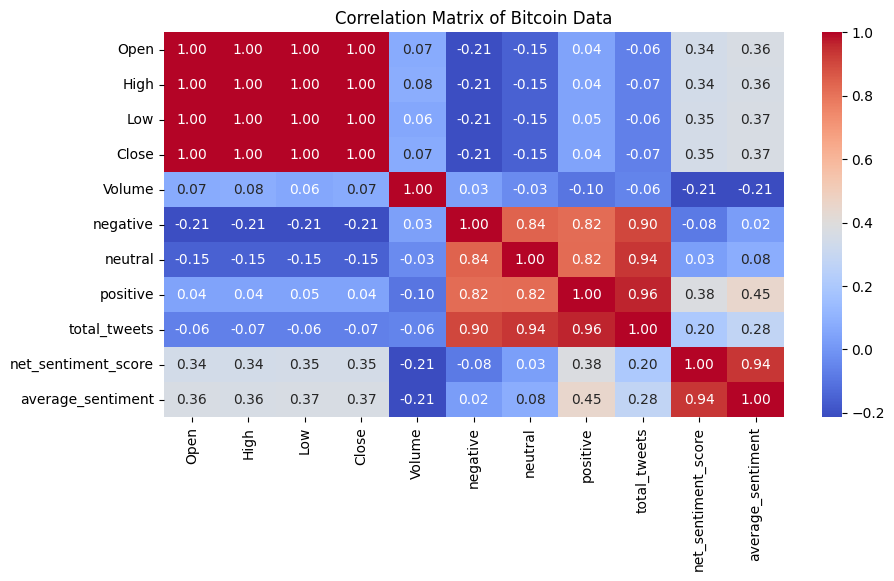

In [109]:
correlation_matrix = merged_df.corr()

plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Bitcoin Data")
plt.show()

Total tweets is highly correlated with net sentiment score (0.94) and average sentiment score (0.96), suggesting that more tweets may contribute to a stronger or more defined sentiment. Average sentiment and net sentiment score show mild positive correlation with Bitcoin price variables (open, high, low, and close). This shows there could be a potential influence of market sentiment on Bitcoin prices, but it is not strong. 

This shows some real promise! The net sentiment score and the average sentiment both have moderate correlation with the Open, High, Low and Close.

Lets explore this further.

This scatterplot shows the relationship between Average Sentiment and BTC Price Low, which had a correlation coefficient of **0.37**


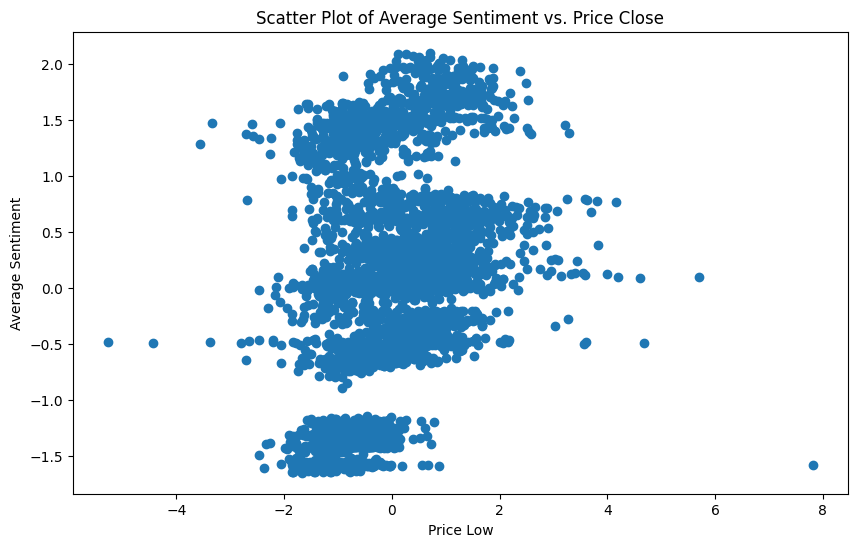

In [110]:
plt.figure(figsize=(10, 6))  
plt.scatter(merged_df_scaled['average_sentiment'], merged_df_scaled['Close'])
plt.ylabel('Average Sentiment')
plt.xlabel('Price Low')
plt.title('Scatter Plot of Average Sentiment vs. Price Close')
plt.show()

We can also analyse how correlation between sentiment and price action changes over time through rolling correlation.

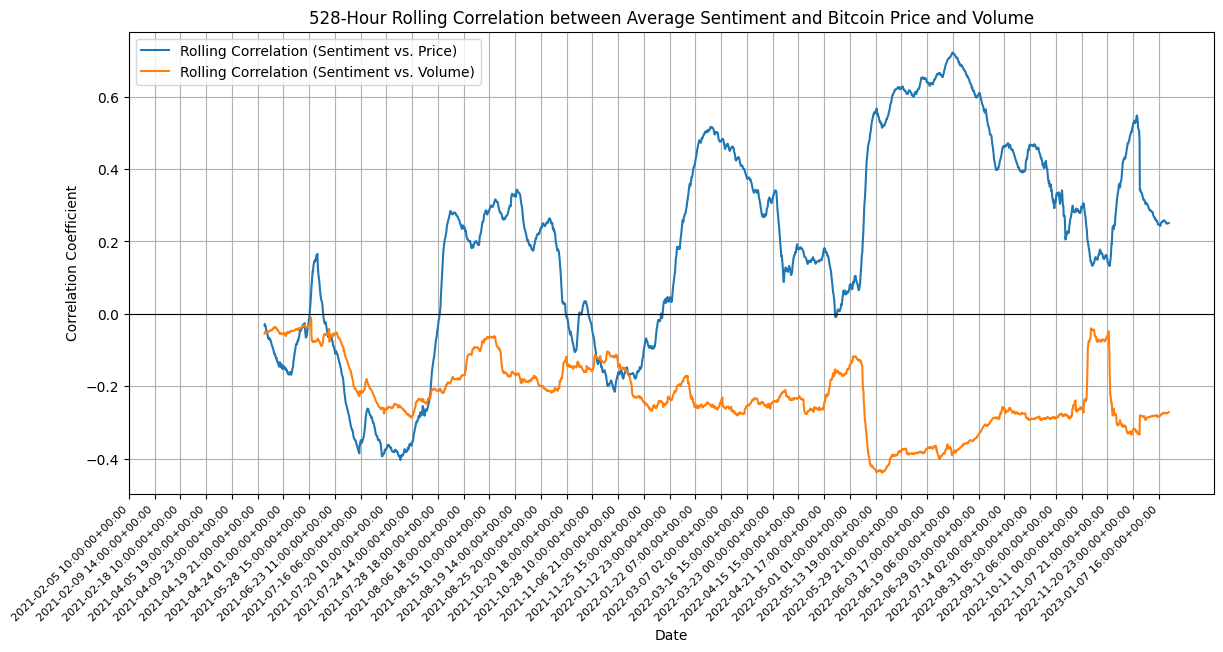

In [111]:
window_size = 528

rolling_corr_price = merged_df_scaled['average_sentiment'].rolling(window=window_size).corr(merged_df_scaled['Close'])

rolling_corr_volume = merged_df_scaled['average_sentiment'].rolling(window=window_size).corr(merged_df_scaled['Volume'])


plt.figure(figsize=(14, 6))
plt.plot(rolling_corr_price, label='Rolling Correlation (Sentiment vs. Price)')
plt.plot(rolling_corr_volume, label='Rolling Correlation (Sentiment vs. Volume)')
plt.title('528-Hour Rolling Correlation between Average Sentiment and Bitcoin Price and Volume')
plt.xlabel('Date')
plt.ylabel('Correlation Coefficient')
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(True)
n = len(merged_df_scaled.index) // 40 
plt.xticks(merged_df_scaled.index[::n])

plt.xticks(rotation=45, ha='right', fontsize=8) 


plt.show()

From the plot above, we can see how correlation between our sentiment and volume and price action change over time. There are periods of high positive correlation, high sentiment leads to high price/volume and vice versa, periods of high negative sentiment, high sentiment leads to low price/volume and vice versa, and periods where there is little to no correlation. 

Something interesting to notice is how in some portions of the time series, the correlation between sentiment and price action, and sentiment and volume seem to be opposites of each other. This could suggest an interesting relationship. A possible reason for this could be that when sentiment is highly correlated with price action, volume goes down because retail traders are taking over the market space and bank traders, who often trade with high volume and order size, are taking a step back from the market. This would make sense as retail traders are the ones who post on social media and contribute to the sentiment we are analysing. 

### Regression Modeling

Another way that we can understand how the sentiment plays a role in determining price action is by making a regressor to model the data and seeing how that performs.

For our regressor, we are going to use `XGBoost` as it is good for time-series data. We will use `total_tweets`, `net_sentiment_score`, and `average_sentiment` as inputs and our target variable is `Close`.

In [112]:
X = merged_df.drop(['Close', 'High', 'Low', 'Open', 'Volume', 'negative',	'neutral',	'positive'], axis=1)
y = merged_df['Close']

train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.2f}")


Mean Squared Error: 220698221.35
Mean Absolute Error: 13719.05
R-squared: -74.33


These results are quite surprising, an `R-squared` of `-74.33` is extremely low and is indicative of a regression model completely failing. Lets plot out our output to get a better understanding of whats going on.

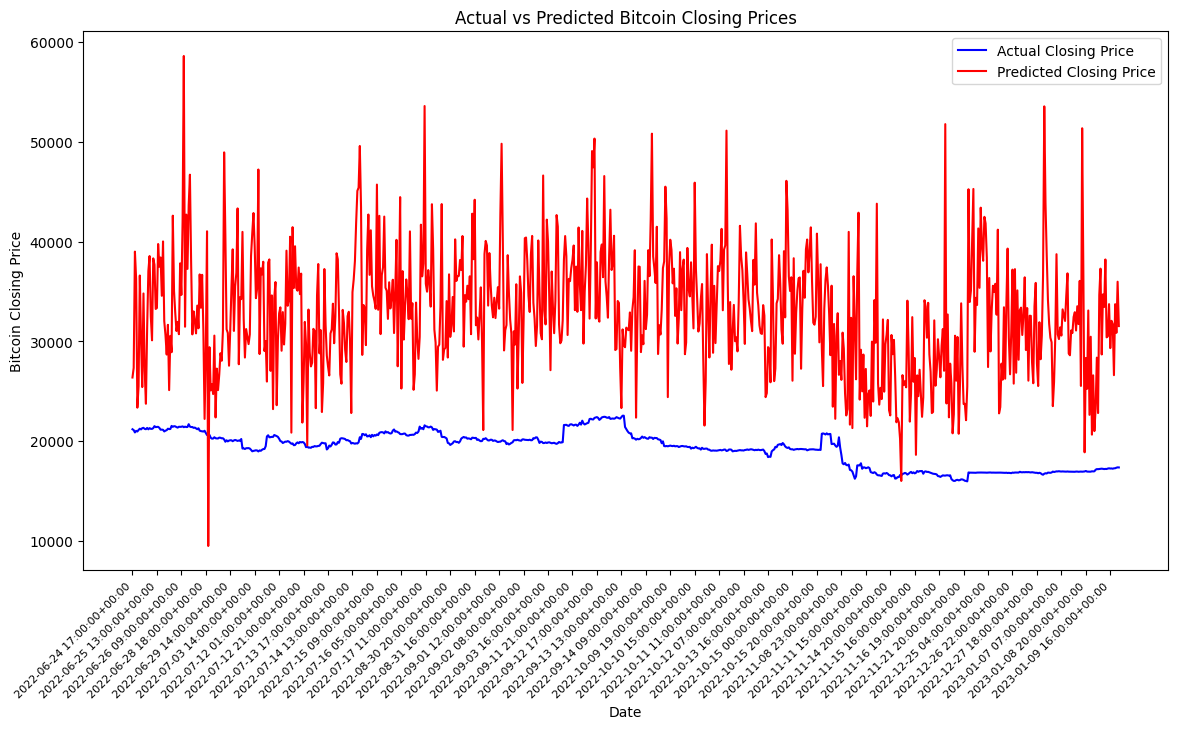

In [113]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Closing Price', color='b')
plt.plot(y_test.index, y_pred, label='Predicted Closing Price', color='r')
plt.xlabel('Date')
plt.ylabel('Bitcoin Closing Price')
plt.title('Actual vs Predicted Bitcoin Closing Prices')
plt.legend()

n = len(y_test.index) // 40  
plt.xticks(y_test.index[::n])
plt.xticks(rotation=45, ha='right', fontsize=8) 

plt.show()


This plot above shows that the regression model was not able to represent and model our bitcoin `Close`, or price action, at all.

Is this a sign that there is absolutely no causality between our sentiment metrics and price action? We can use a statistical test called the `Granger Causality` test to find out. This test analyses the effect that one time series has on the other, adding direction to our correlation.

In [114]:
def perform_granger_test(cause, effect, maxlag=12, alpha=0.05):
    data = pd.DataFrame({'effect': effect, 'cause': cause})

    test_result = grangercausalitytests(data[['effect', 'cause']], maxlag=maxlag, verbose=False)

    print(f"Granger Causality Test Results ({cause.name} -> {effect.name}):")
    significant_lags = []
    for lag in range(1, maxlag + 1):
        p_value = round(test_result[lag][0]['ssr_ftest'][1], 4)
        print(f"Lag {lag}: P-value = {p_value}")
        if p_value < alpha:
            significant_lags.append(lag)

    if significant_lags:
        print(f"\n{cause.name} Granger causes {effect.name} at lags: {significant_lags} (significance level {alpha})\n")
    else:
        print(f"\n{cause.name} does not Granger cause {effect.name} at any tested lag (significance level {alpha})\n")


In [118]:
# Granger Causality Test: average_sentiment -> Bitcoin Price
perform_granger_test(
    cause=merged_df_no_na['average_sentiment'], 
    effect=merged_df_no_na['Close'], 
    maxlag=12, 
    alpha=0.05
)

# Granger Causality Test: net_sentiment_score -> Bitcoin Price
perform_granger_test(
    cause=merged_df_no_na['net_sentiment_score'], 
    effect=merged_df_no_na['Close'], 
    maxlag=12, 
    alpha=0.05
)


# Granger Causality Test: Bitcoin Price -> Sentiment
perform_granger_test(
    cause=merged_df_no_na['Close'], 
    effect=merged_df_no_na['average_sentiment'], 
    maxlag=12, 
    alpha=0.05
)

# Granger Causality Test: Bitcoin Price -> net_sentiment_score
perform_granger_test(
    cause=merged_df_no_na['Close'], 
    effect=merged_df_no_na['net_sentiment_score'], 
    maxlag=12, 
    alpha=0.05
)

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Granger Causality Test Results (average_sentiment -> Close):
Lag 1: P-value = 0.4288
Lag 2: P-value = 0.7069
Lag 3: P-value = 0.5942
Lag 4: P-value = 0.7615
Lag 5: P-value = 0.8534
Lag 6: P-value = 0.9127
Lag 7: P-value = 0.9552
Lag 8: P-value = 0.9017
Lag 9: P-value = 0.9248
Lag 10: P-value = 0.5511
Lag 11: P-value = 0.604
Lag 12: P-value = 0.5335

average_sentiment does not Granger cause Close at any tested lag (significance level 0.05)

Granger Causality Test Results (net_sentiment_score -> Close):
Lag 1: P-value = 0.2228
Lag 2: P-value = 0.4313
Lag 3: P-value = 0.5306
Lag 4: P-value = 0.707
Lag 5: P-value = 0.7605
Lag 6: P-value = 0.7835
Lag 7: P-value = 0.8397
Lag 8: P-value = 0.8934
Lag 9: P-value = 0.9313
Lag 10: P-value = 0.8043
Lag 11: P-value = 0.7516
Lag 12: P-value = 0.776

net_sentiment_score does not Granger cause Close at any tested lag (significance level 0.05)

Granger Causality Test Results (Close -> average_sentiment):
Lag 1: P-value = 0.0
Lag 2: P-value = 0.0
Lag 3:

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


From the test above we see that `average_sentiment` or `net_sentiment_score` were unable to get a P-value low enough to show that they have causality on `Close`, or BTC Price Action for every Lag step. On the other hand, `Close`, was able to show very low P-values, indicating that it has a valid causality on both our sentiment metrics at every lag.

This means that the correlation that we measured between sentiment and price action was not causal in the direction of Sentiment -> Price but instead Price -> Sentiment. 

This also explains why our regression model wasn't able to model the data at all.

We can actually try creating a regression model in the opposite direction, using price metrics to model sentiment and see how it performs.

In [116]:
X = merged_df.drop(['total_tweets', 'net_sentiment_score', 'average_sentiment', 'negative',	'neutral',	'positive'], axis=1)
y = merged_df['average_sentiment']

train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 0.00
Mean Absolute Error: 0.03
R-squared: -0.28


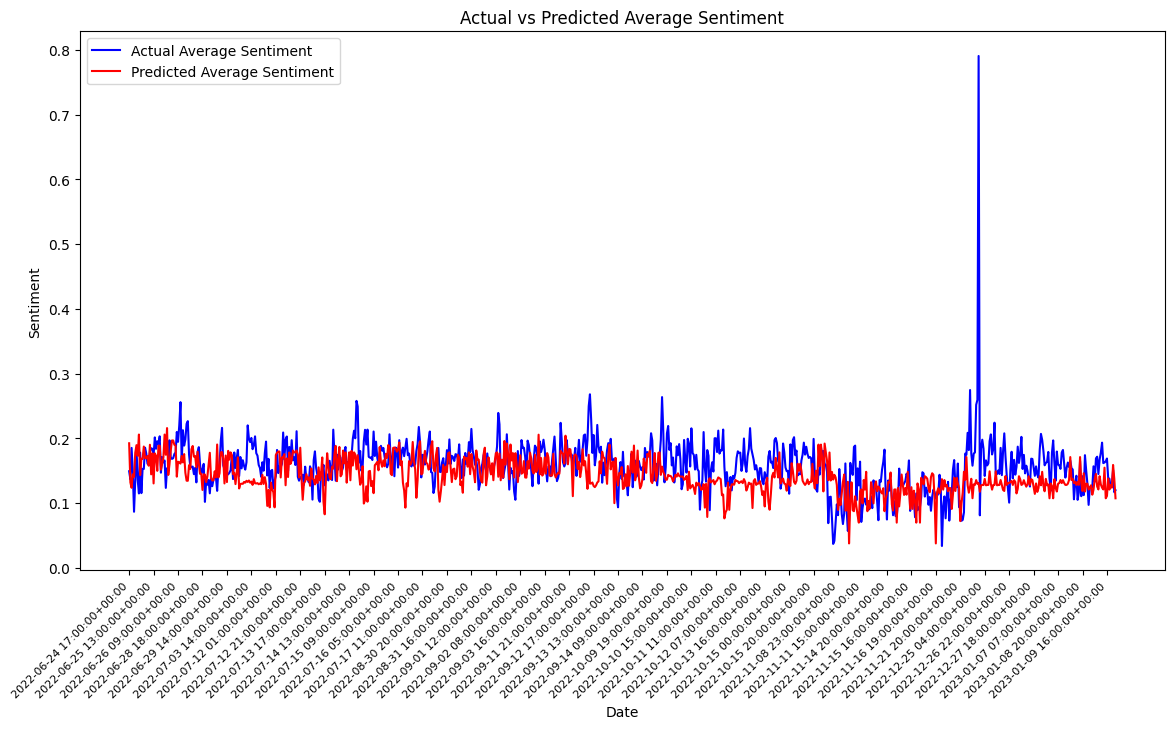

In [117]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Average Sentiment', color='b')
plt.plot(y_test.index, y_pred, label='Predicted Average Sentiment', color='r')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Actual vs Predicted Average Sentiment')
plt.legend()

n = len(y_test.index) // 40  
plt.xticks(y_test.index[::n])
plt.xticks(rotation=45, ha='right', fontsize=8) 

plt.show()

This model performs much better compared to when we tried to apply it to predicting `Close` with sentiment metrics.

# Ethics & Privacy

In our data science project, we prioritize ethics and privacy by using only open-source datasets that adhere to strict data usage policies, ensuring we respect data ownership and compliance with privacy regulations.

Bitcoin data is publicly available and doesn’t raise any violations on privacy and ethics. Analyzing social media sentiment does raise some flags on the use of peoples opinions and posts to represent and train our sentiment model but all scraped data will come from public posts.

Conducting sentiment analysis on social media platforms inherently carries risks of bias. Different sentiment tones can arise due to cultural, linguistic, and regional aspects. Additionally, sentiment extraction methods may amplify certain viewpoints or under-represent others, leading to biased outcomes in our analysis. For instance, words or phrases with different meanings across regions can cause sentiment scores to differ and be inaccurate.

To mitigate these biases, we employ normalization techniques and careful preprocessing steps to ensure that our sentiment model is as objective as possible. This includes standardizing language differences, and removing outliers. Furthermore, we plan to perform a bias audit on our model’s outputs to identify and address any unintended skew in our results.

# Discussion and Conclusion

#### Discussion:
In our data analysis, sentiment metrics failed to effectively predict Bitcoin price movements, as demonstrated by the poor performance of regression models (R² ≈ -74) and failure to show causality through Granger Causality Test. This suggests that market sentiment alone is not a primary indicator of price changes in the cryptocurrency market.

However, our analysis uncovered that Bitcoin price movements appear to influence public sentiment. The Granger Causality Test revealed that while sentiment (average or net) did not Granger-cause Bitcoin prices, Bitcoin price changes did Granger-cause sentiment metrics. This indicates a directional relationship where significant price fluctuations may drive public sentiment on social media platforms. This finding is seen in our second regression model, which showed that Bitcoin prices could better predict sentiment trends than the reverse, as evidenced by a smaller Mean Squared Error and a more reasonable R² value that is closer to 1.

This makes logical sense as high stakes financial markets are bound to have an emotional effect on those that participate in it and this effect is reflected in their social media posts. 

Our work builds upon the prior studies mentioned in our background section that demonstrates links between social media sentiment and Bitcoin prices, such as the study on Twitter’s “public mood” and its connection to price volatility and the analysis of Reddit discussion about cryptocurrency. While these previous studies emphasize the influence of sentiment on price movement, our findings demonstrate the reverse nature of this relationship, with a stronger influence on how price drives social media sentiment. Again, this relationship makes sense that the dynamic nature of cryptocurrency prices can affect the social media users emotionally. 

##### Limitations and Challenges:
One major challenge was the high noise in sentiment data, which is inherent to social media platforms where content varies widely in quality, context, and relevance. Additionally, the weak causality between sentiment metrics and price trends highlight the difficulty of using sentiment as a standalone predictor in a market influenced by multiple external factors, including macroeconomic events, regulatory news, and market manipulation.

Another limitation stems from the dynamic nature of both sentiment and financial markets. There are many variables that play that predict price action, motivations of market movers, retail traders, economic policy, etc. Because of this, sentiment data about Bitcoin from Twitter/X isn’t enough to really model and predict price action. Instead it should be used as a possible indicator alongside other metrics if price action is really to be modeled and predicted. 

Our analysis was constrained by the time period and dataset used, which only had data from 2021 to 2023, which may not fully capture long-term trends or sudden, impactful events like market crashes or surges, events where sentiment from social media could be a big indicator.

#### Conclusion:

Our research question was, “Can we identify a measurable correlation/causality between specific social media sentiment indicators on platforms like X (formerly Twitter), and key Bitcoin price metrics?

Through our analysis, we were unable to establish a causality between sentiment and Bitcoin price action, ultimately rejecting our initial hypothesis.

Despite these limitations, this project provided valuable insights and hands-on experience with key techniques in data analysis. We successfully applied the foundational methods taught in COGS108, including data gathering, cleaning, exploratory data analysis (EDA), hypothesis testing, and visualization. The project taught us the importance of examining data through multiple perspectives, such as statistical tests, graphical representations, and machine learning models, to develop an understanding of complex statistical relationships among datasets.

While our findings do not support the predictive power of sentiment metrics for Bitcoin prices, they demonstrated the nuanced relationship between market behavior and public sentiment. Future research could build on this work by incorporating more advanced natural language processing techniques, a broader dataset including multiple social media platforms, or additional external factors such as global news or macroeconomic events.

In conclusion, our study aims to look at the causality between social media sentiment and Bitcoin market behavior. We ultimately found that for our dataset, social media sentiment did not have a significant impact on predicting Bitcoin market behaviour and price action, instead learning that there is a strong causal relationship between Bitcoin market behavior and social media sentiment.


# Team Contributions

Specify who did what. This should be pretty granular, perhaps bullet points, no more than a few sentences per person.

- Parv Chordiya: Data Wrangling, Sentiment Analysis, EDA2
- Vivek Rane: Finding Datasets, Data Cleaning, EDA, Correlation Matrix
- Sonakshi Mohanty: Discussion, Limitations, Conclusion, Analyzing Code for Description, Team Expectations
- Rahul Bulsara: Overview, Discussion, Ethics and Privacy Concerns